In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import ot
from sklearn.datasets import make_moons
import os
os.chdir('/home/baly/projects/PGW_Metric')

from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn,log_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost
from lib.unbalanced_gromov_wasserstein.unbalancedgw.utils import generate_measure
from lib.unbalanced_gromov_wasserstein.unbalancedgw.batch_stable_ugw_solver import log_batch_ugw_sinkhorn
from lib.gromov import gromov_wasserstein, cost_matrix_d, partial_gromov_ver1, GW_dist, MPGW_dist, PGW_dist_with_penalty,partial_gromov_wasserstein

In [17]:
def rotation_2d(theta=0):
    return np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]
    ])


def make_moon_2d(N=200, eta=0.10, ns=0.05,theta=0,beta=0,low=-3,high=-2):
    X, y = make_moons(n_samples=N, noise=ns)
    
    X1=X[y==0]
    X2=X[y==1]
    X2=X2.dot(rotation_2d(theta))+beta
    N=X1.shape[0]
    #outlier_idx = np.random.choice(np.where(y == 0)[0], int(N*eta))
    outliers = np.random.uniform(low=low, high=high, size=(int(N*eta), 2))
    return X1, X2,outliers

def make_3d(N=200, o=0.2, d_min=0.5):
    circle = np.random.uniform(low=0, high=2*np.pi, size=(N, 1))
    circle = np.hstack((np.cos(circle), np.sin(circle), np.zeros_like(circle)))

    phi = np.random.uniform(0, np.pi, N)
    theta = np.random.uniform(0, 2*np.pi, N)
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    sphere = np.stack((x, y, z), axis=1) * 0.7
    sphere += np.array([0.5, 0, 2.5])
    
    n_outliers = int(N*o)
    outliers = sphere[np.random.choice(sphere.shape[0], n_outliers, replace=True)]
    outliers += np.random.uniform(low=-1.0, high=1.0, size=outliers.shape)
    
    while True:
        ds = np.linalg.norm(outliers[:, np.newaxis] - sphere, axis=2)
        min_ds = np.min(ds, axis=1)
        if np.all(min_ds > d_min): break
        outliers[min_ds <= d_min] += np.random.uniform(low=-1.0, high=1.0, size=(np.sum(min_ds <= d_min), 3))
    
    sphere = np.vstack((sphere, outliers))
    
    return circle, sphere, np.concatenate((np.zeros(N), np.ones(n_outliers)))

# def plot_2d(X1, X2):
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', s=20)
#     plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b', s=20)
#     plt.scatter(X[y == 2, 0], X[y == 2, 1], c='c', s=20)
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

def plot_2d(X1, X2):
    plt.figure(figsize=(8, 6))
    plt.scatter(X1[:,0], X1[:,1], c='r', s=20)
    plt.scatter(X2[:,0], X2[:, 1], c='b', s=20)
    #plt.scatter(X[y == 2, 0], X[y == 2, 1], c='c', s=20)
    #plt.xticks([])
    #plt.yticks([])
    plt.show()



def plot_3d(circle, sphere, labels):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(circle[:, 0], circle[:, 1], circle[:, 2], c='r', s=20)
    ax.scatter(sphere[labels == 0, 0], sphere[labels == 0, 1], sphere[labels == 0, 2], c='b', s=20)
    ax.scatter(sphere[labels == 1, 0], sphere[labels == 1, 1], sphere[labels == 1, 2], c='c', s=20)
    
    ax.set_box_aspect([1,1,1])
    ax.view_init(elev=20, azim=45)
    plt.tight_layout()
    
    plt.show()
    
def get_cost_matrices(X, Y):
    C1 = cost_matrix_d(X, X)
    C2 = cost_matrix_d(Y, Y)
    return C1, C2


def plot_plan_2d(X, Y, gamma,threshold=1e-8):
    plt.figure(figsize=(8, 6))
    N=X.shape[0]
    plt.scatter(X[:,0], X[:, 1], c='r')
    
    plt.scatter(Y[0:N,0], Y[0:N,1], c='c')
    plt.scatter(Y[N+1:,0],  Y[N+1:,1], c='b')
    
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            if gamma[i, j] > threshold:  plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], 'grey', lw=gamma[i, j]*150, alpha=0.4)

    plt.show()
    
def plot_plan_3d(X, Y, gamma, labels_src):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X[labels_src == 0, 0], X[labels_src == 0, 1], X[labels_src == 0, 2], c='b')
    ax.scatter(X[labels_src == 1, 0], X[labels_src == 1, 1], X[labels_src == 1, 2], c='c')
    ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c='r')
    
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            if gamma[i, j] > 0:  ax.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], [X[i, 2], Y[j, 2]], 'grey', lw=gamma[i, j]*150,alpha=0.4)

    plt.show()

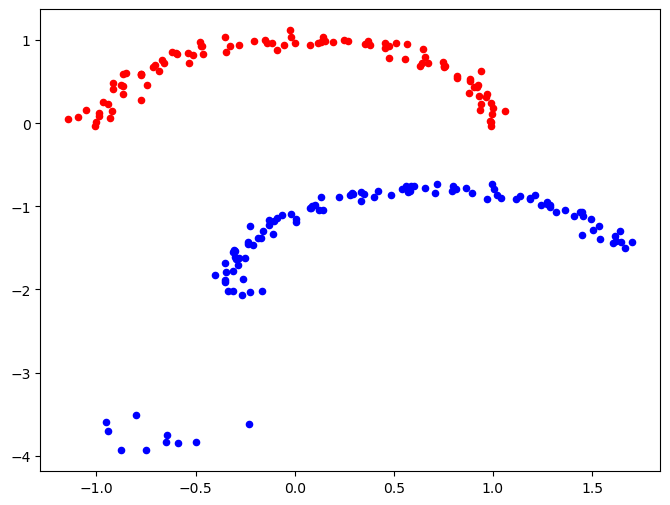

In [18]:
X1,X2,outliers = make_moon_2d(N=200,eta=0.10, ns=0.05,theta=0.9*np.pi,beta=[1.5,-1],low=[-1,-4],high=[0,-3.5])
X2=np.vstack((X2,outliers))

plot_2d(X1,X2)


# circle, sphere, labels_3d = make_3d()
# plot_3d(circle, sphere, labels_3d)

PGW lambda=0.01: transport cost=2.9850766879210457, penalty=0.007649999999999999, distance=2.9927266879210457


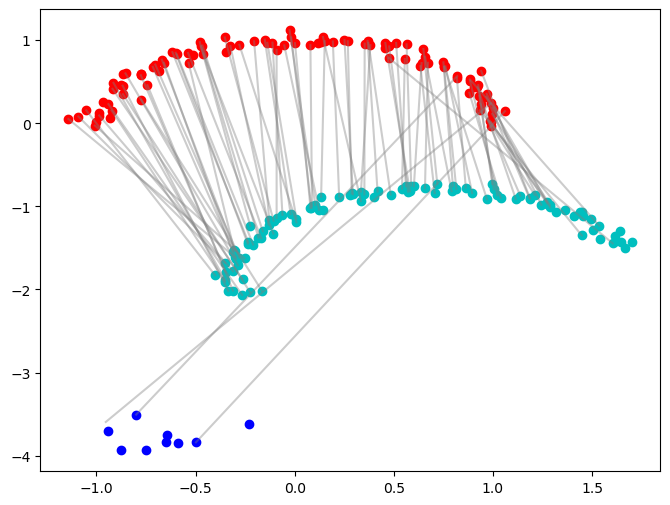

PGW lambda=0.1: transport cost=0.00852221528980256, penalty=0.05171999999999999, distance=0.060242215289802545


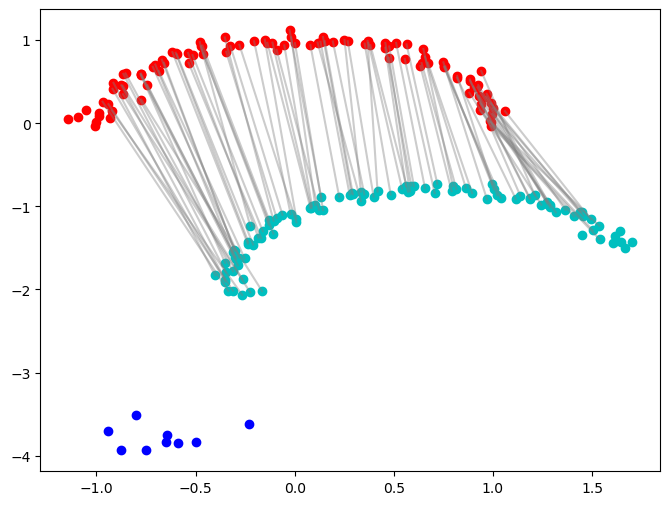

PGW lambda=1.0: transport cost=0.017108689719822677, penalty=0.20999999999999996, distance=0.22710868971982265


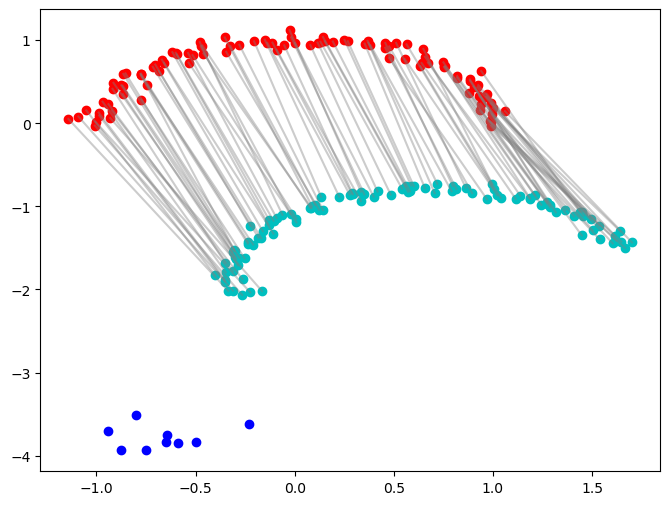

PGW lambda=10: transport cost=0.01710868971982267, penalty=2.099999999999995, distance=2.1171086897198177


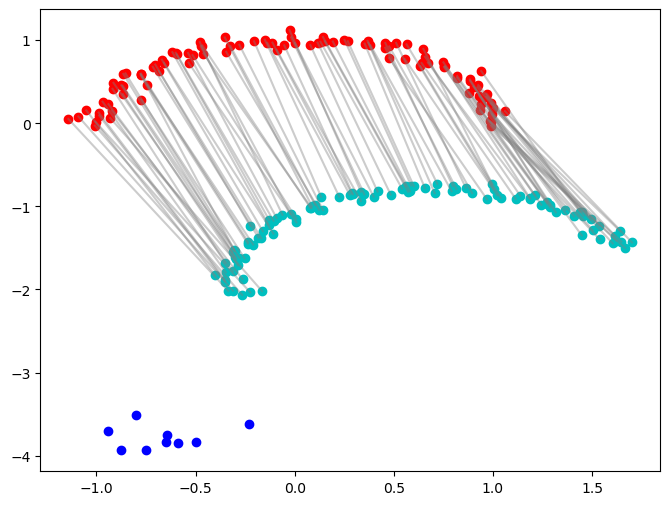

mPGW m=0.9999999999999999: transport cost=0.01710868971982267, penalty=2.099999999999995, distance=2.1171086897198177


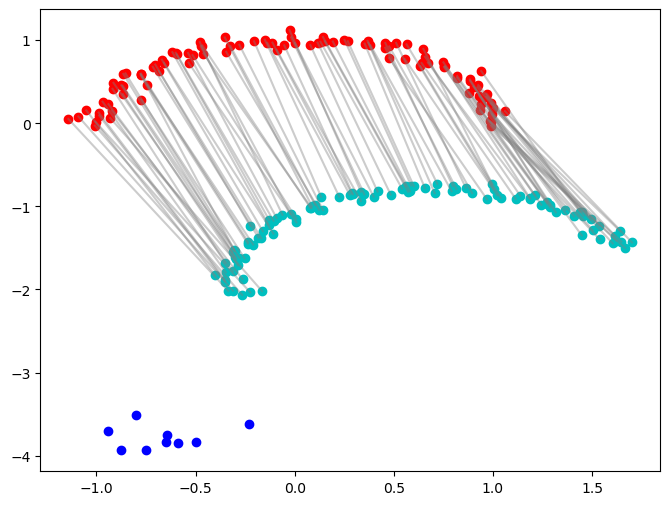

UGW rho=0.01: cost=0.4795112907886505


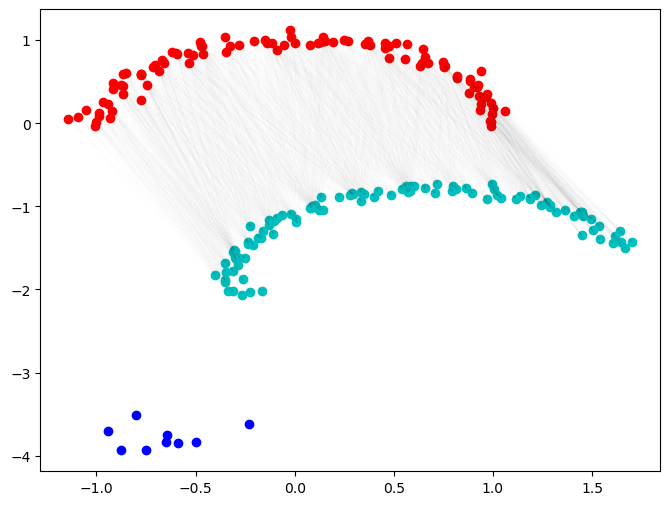

UGW rho=0.1: cost=0.6199492812156677


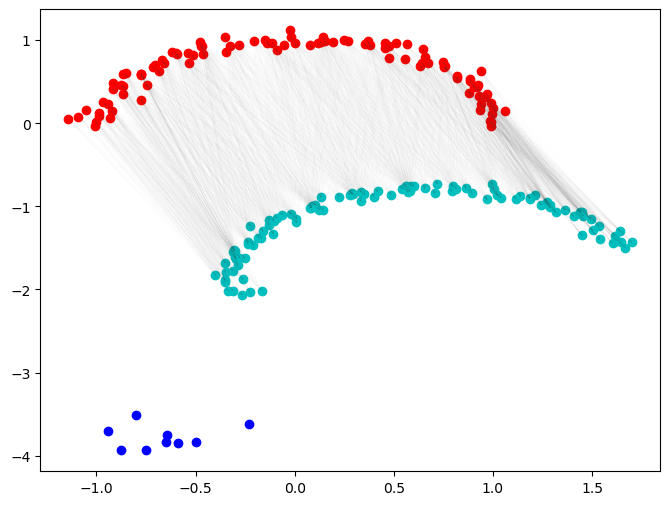

UGW rho=1.0: cost=1.2328886985778809


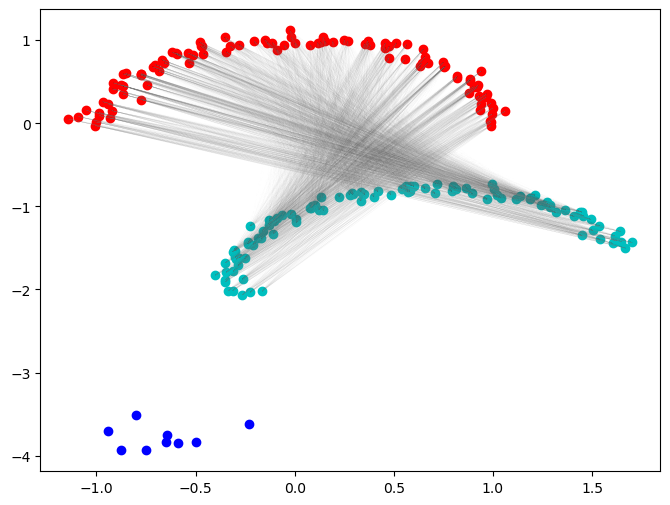

UGW rho=10: cost=3.3148531913757324


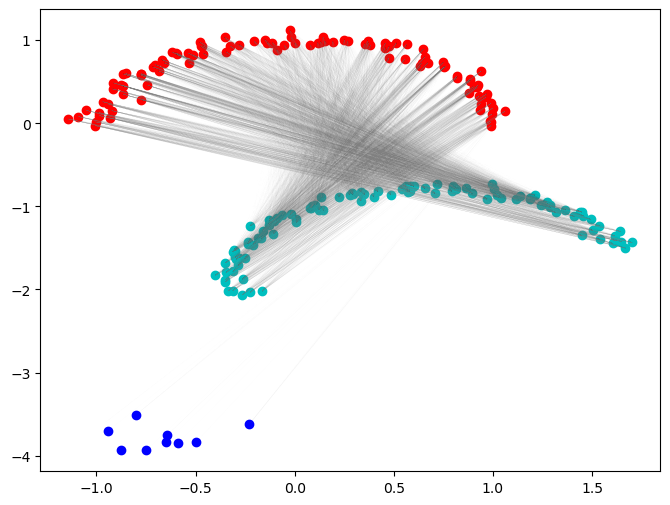

GW : 7.651859229859178


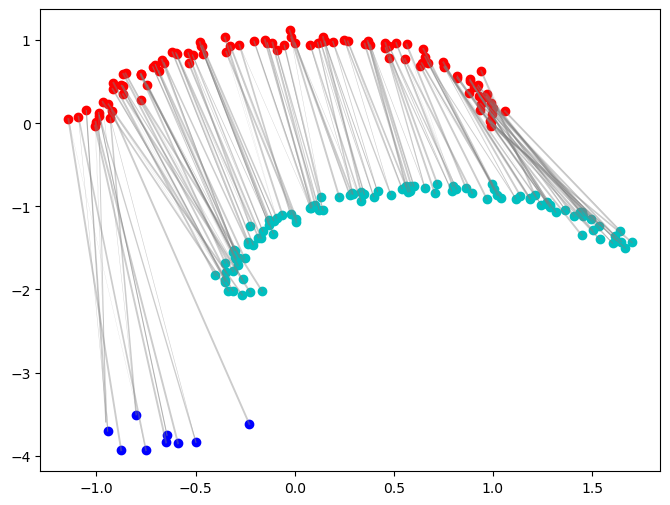

In [21]:

#PGW
lams = [1e-2, 1e-1, 1e0, 10]
pgw_list,mpgw_list,ugw_list,gw_list=[],[],[],[]
for lam in lams:
    #X_src = X_2d[y_2d != 0]  
    #y_src = y_2d[y_2d != 0]
    #X_tar = X_2d[y_2d == 0]  
    
    N1,N2=X1.shape[0],X2.shape[0]
    
    p = np.ones(N1) / N1
    q = np.ones(N2) / N1
    C1,C2=cost_matrix_d(X1,X1),cost_matrix_d(X2,X2)
    gamma = partial_gromov_ver1(C1, C2, p, q, G0=None, Lambda=lam, thres=1, numItermax=100*N1, tol=1e-5, log=False, verbose=False, line_search=False)
    pgw_trans, pgw_penalty = PGW_dist_with_penalty(C1, C2, gamma, p, q, lam)
    pgw_D = pgw_trans + pgw_penalty
    
    print(f'PGW lambda={lam}: transport cost={pgw_trans}, penalty={pgw_penalty}, distance={pgw_D}')
    
    plot_plan_2d(X1, X2, gamma, threshold=1e-5)
    pgw_list.append(gamma)
    

    
N1,N2=X1.shape[0],X2.shape[0]

p = np.ones(N1) / N1
q = np.ones(N2) / N1
C1,C2=cost_matrix_d(X1,X1),cost_matrix_d(X2,X2)
gamma = partial_gromov_wasserstein(C1, C2, p, q, G0=None, m=min(p.sum(),q.sum()), thres=1, numItermax=100*N1, tol=1e-5, log=False, verbose=False, line_search=False)
mpgw_list.append(gamma)
print(f'mPGW m={p.sum()}: transport cost={pgw_trans}, penalty={pgw_penalty}, distance={pgw_D}')
plot_plan_2d(X1, X2, gamma, threshold=1e-5)


    



rhos = [1e-2, 1e-1, 1e0, 10]
for rho in rhos:
#     X_src = X_2d[y_2d == 0]
#     y_src = y_2d[y_2d != 0]
#     X_tar = X_2d[y_2d == 0]
    
    p = np.ones(X1.shape[0]) / N1
    q = np.ones(X2.shape[0]) / N1
    C1, C2 = cost_matrix_d(X1,X1),cost_matrix_d(X2,X2)
    eps = 0.4
    Cx = torch.from_numpy(C1).to(torch.float32)
    Cy = torch.from_numpy(C2).to(torch.float32)
    mu = torch.from_numpy(p).to(torch.float32)
    nu = torch.from_numpy(q).to(torch.float32)
    
    gamma = log_batch_ugw_sinkhorn(mu.unsqueeze(0), Cx.unsqueeze(0), nu.unsqueeze(0), Cy.unsqueeze(0), init=None, eps=eps, rho=rho, rho2=rho, nits_plan=3000, tol_plan=1e-5, nits_sinkhorn=3000, tol_sinkhorn=1e-6)
    gamma = gamma.squeeze().detach().cpu().numpy()
    ugw_list.append(gamma)
    ugw_cost_value = ugw_cost(torch.tensor(gamma), torch.tensor(gamma), mu, Cx, nu, Cy, eps=eps, rho=rho, rho2=rho)
    
    print(f'UGW rho={rho}: cost={ugw_cost_value}')
    plot_plan_2d(X1, X2, gamma, threshold=1e-5)


#GW

p = np.ones(X1.shape[0]) / N1
q = np.ones(X2.shape[0]) / N2
C1, C2 = cost_matrix_d(X1,X1),cost_matrix_d(X2,X2)
gamma = gromov_wasserstein(C1, C2, p, q, G0=None, thres=1, numItermax=100*N1, tol=1e-5, log=False, verbose=False, line_search=False)
gw_list.append(gamma)
gw_dist = GW_dist(C1, C2, gamma)
print(f'GW : {gw_dist}')
plot_plan_2d(X1, X2, gamma, threshold=1e-5)

result={}
result['pgw'],result['mpgw'],result['ugw'],result['gw']=pgw_list,mpgw_list,ugw_list,gw_list

torch.save(result,'2d_shape_matching/result/gammas.pt')

In [13]:
torch.save(result,'2d_shape_matching/result/gammas.pt')

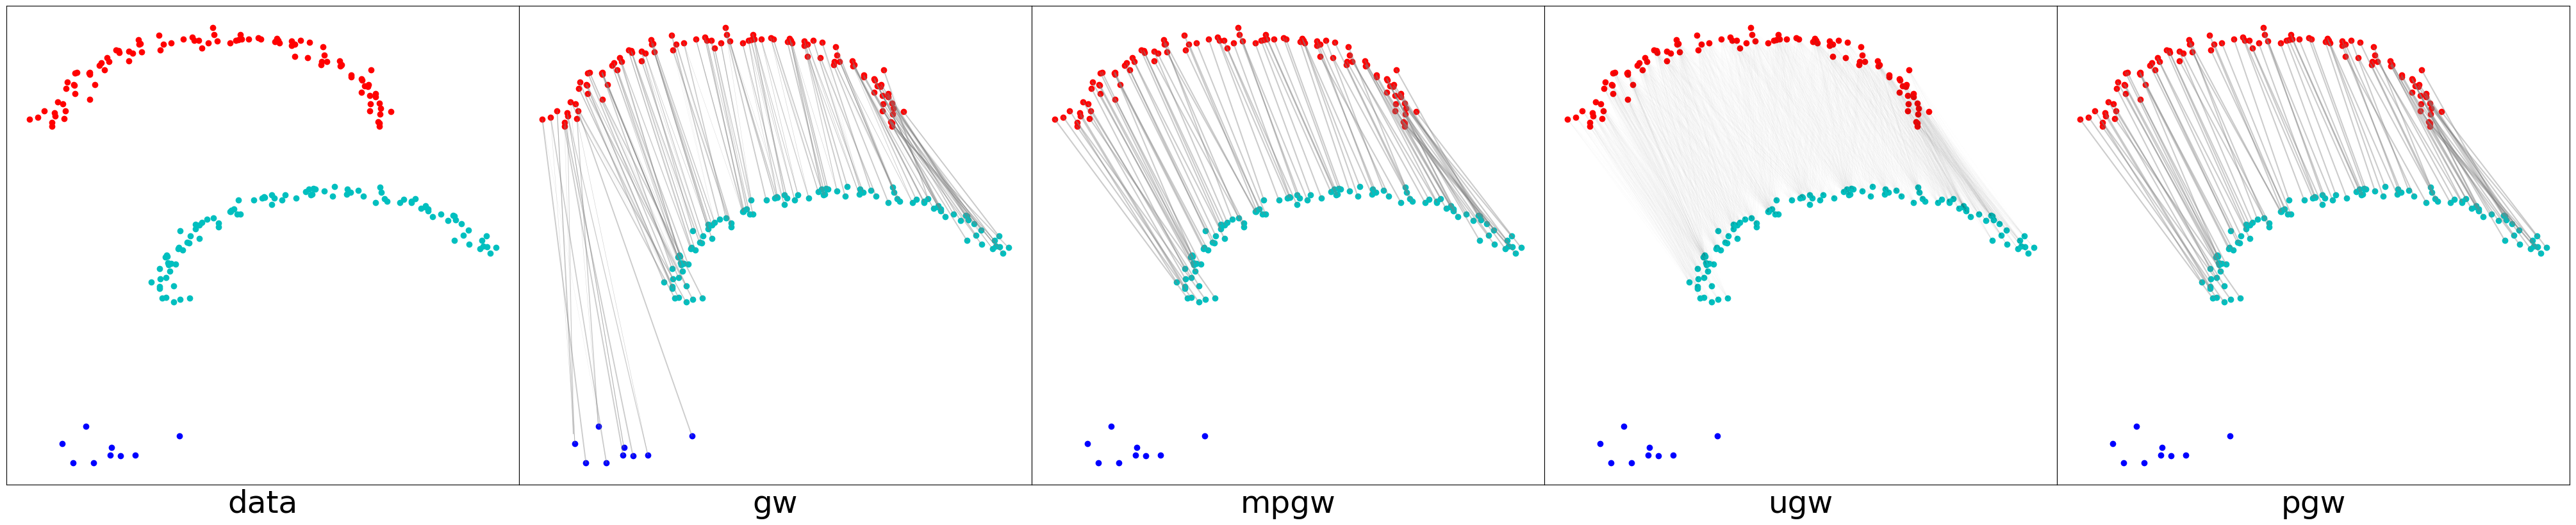

In [35]:
method=['gw','mpgw','ugw','pgw'] #['pgw'],result['mpgw'],result['ugw'],result['gw']
fig, ax = plt.subplots(1, 5, figsize=(40, 8))
threshold=1e-5

ax[0].scatter(X1[:,0], X1[:, 1], c='r')
    
ax[0].scatter(X2[0:N,0], X2[0:N,1], c='c')
ax[0].scatter(X2[N+1:,0],  X2[N+1:,1], c='b')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('data', fontsize=35)

for idx,method in enumerate(method):
    idx=idx+1
    result_list=result[method]
    gamma=result_list[-1]
    if method=='ugw':
        gamma=result_list[1]

    N=X1.shape[0]
    ax[idx].scatter(X1[:,0], X1[:, 1], c='r')
    
    ax[idx].scatter(X2[0:N,0], X2[0:N,1], c='c')
    ax[idx].scatter(X2[N+1:,0],  X2[N+1:,1], c='b')
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_xlabel(method, fontsize=35)
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            if gamma[i, j] > threshold:  ax[idx].plot([X1[i, 0], X2[j, 0]], [X1[i, 1], X2[j, 1]], 'grey', lw=gamma[i, j]*150, alpha=0.4)

plt.tight_layout(pad=0.0)
plt.savefig('2d_shape_matching/2D_shape.png', dpi=200,bbox_inches='tight')
plt.savefig('2d_shape_matching/2D_shape.pdf', dpi=200,bbox_inches='tight')
    
plt.show()


GW : 6.561695001734547


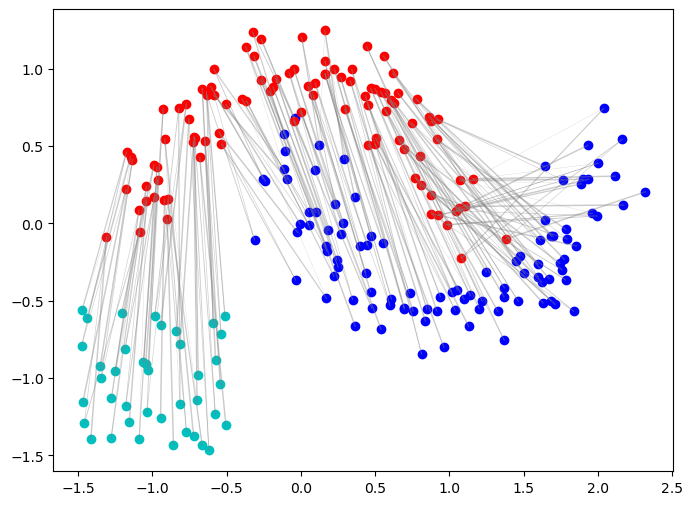

PGW lambda=0.01 for 3D: transport cost=4.037178693858962, penalty=2.220446049250313e-18, distance=4.037178693858962


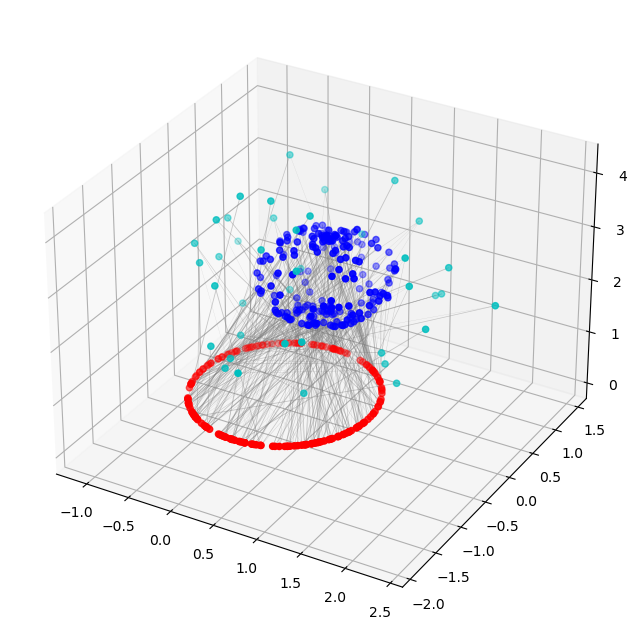

PGW lambda=0.1 for 3D: transport cost=3.9743264480737563, penalty=2.2204460492503132e-17, distance=3.9743264480737563


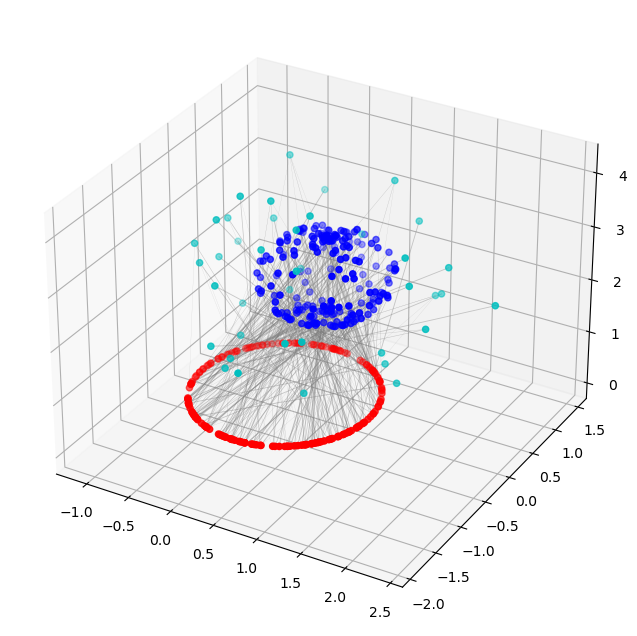

PGW lambda=1.0 for 3D: transport cost=4.042855779207127, penalty=0.016631944444443825, distance=4.0594877236515705


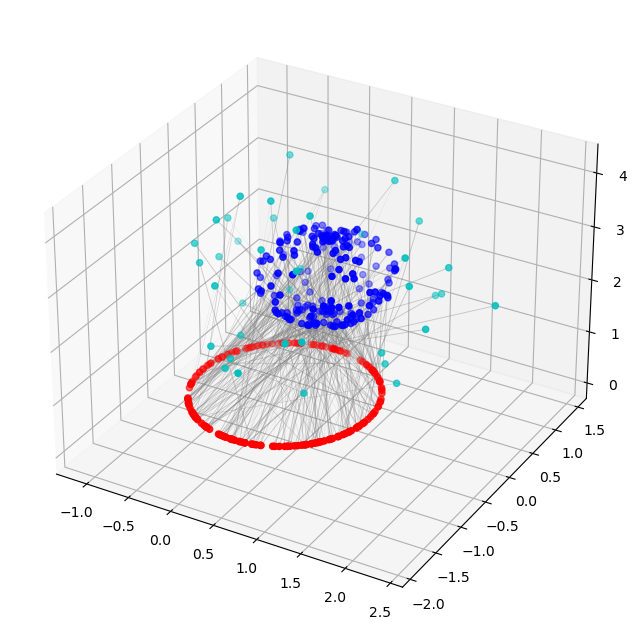

PGW lambda=10 for 3D: transport cost=2.14294366805977, penalty=-6.661338147750939e-15, distance=2.1429436680597633


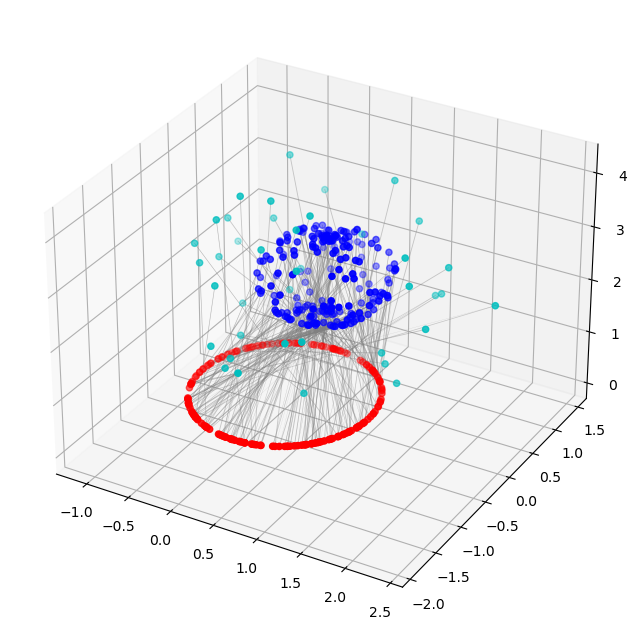

UGW  rho=0.01 for 3D: cost=0.023535054177045822


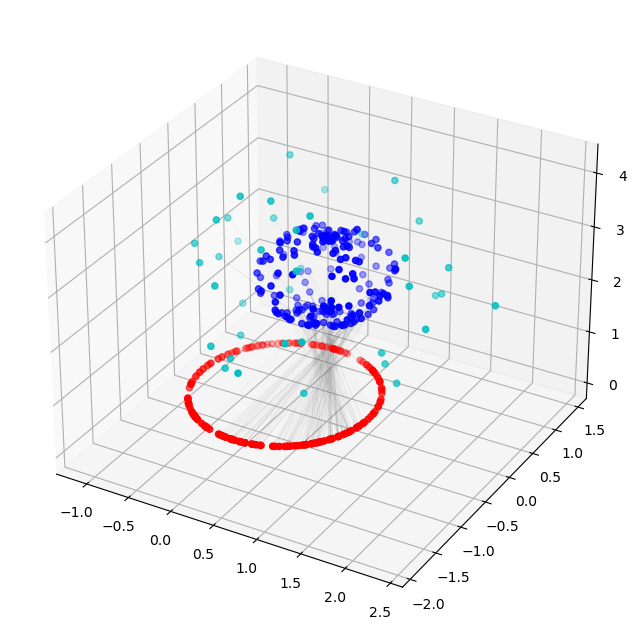

UGW  rho=0.1 for 3D: cost=0.17163732647895813


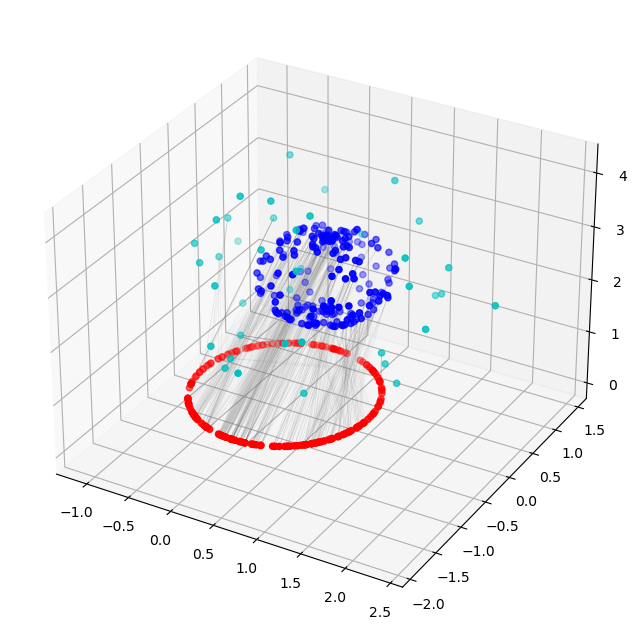

UGW  rho=1.0 for 3D: cost=0.9624838829040527


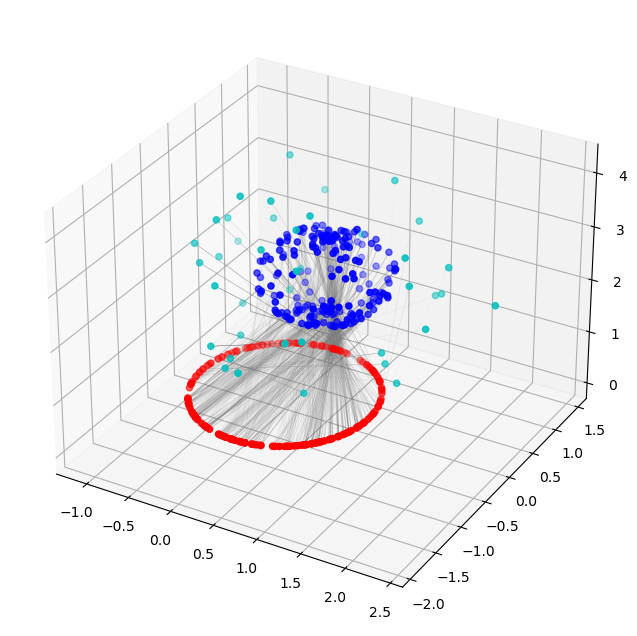

UGW  rho=10 for 3D: cost=1.9928961992263794


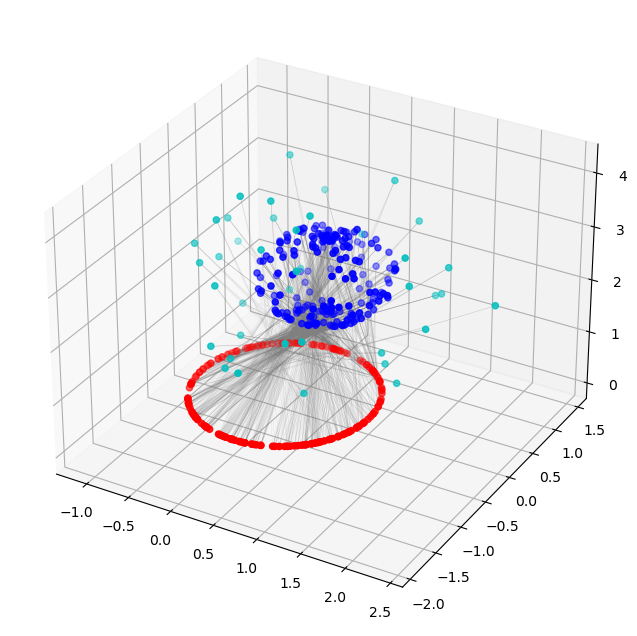

In [18]:
#GW
X_src = X_2d[y_2d != 0] 
y_src = y_2d[y_2d != 0]
X_tar = X_2d[y_2d == 0] 
p = np.ones(X_src.shape[0]) / X_src.shape[0]
q = np.ones(X_tar.shape[0]) / X_tar.shape[0]
C1, C2 = get_cost_matrices(X_src, X_tar)
gamma = gromov_wasserstein(C1, C2, p, q, G0=None, thres=1, numItermax=100*X_src.shape[0], tol=1e-5, log=False, verbose=False, line_search=False)
gw_dist = GW_dist(C1, C2, gamma)
print(f'GW : {gw_dist}')
plot_plan_2d(X_src, X_tar, gamma, y_src)


for lam in lams:
    X_src = sphere 
    labels_src = labels_3d
    X_tar = circle  
    p = np.ones(X_src.shape[0]) / X_src.shape[0]
    q = np.ones(X_tar.shape[0]) / X_tar.shape[0]
    C1, C2 = get_cost_matrices(X_src, X_tar)
    
    gamma = partial_gromov_ver1(C1, C2, p, q, G0=None, Lambda=lam, thres=1, numItermax=100*X_src.shape[0], tol=1e-5, log=False, verbose=False, line_search=False)
    pgw_trans, pgw_penalty = PGW_dist_with_penalty(C1, C2, gamma, p, q, lam)
    pgw_D = pgw_trans + pgw_penalty
    
    print(f'PGW lambda={lam} for 3D: transport cost={pgw_trans}, penalty={pgw_penalty}, distance={pgw_D}')
    plot_plan_3d(X_src, X_tar, gamma, labels_src)

for rho in rhos:
    X_src = sphere 
    labels_src = labels_3d
    X_tar = circle  
    p = np.ones(X_src.shape[0]) / X_src.shape[0]
    q = np.ones(X_tar.shape[0]) / X_tar.shape[0]
    C1, C2 = get_cost_matrices(X_src, X_tar)
    
    eps = 0.004
    Cx = torch.from_numpy(C1).to(torch.float32)
    Cy = torch.from_numpy(C2).to(torch.float32)
    mu = torch.from_numpy(p).to(torch.float32)
    nu = torch.from_numpy(q).to(torch.float32)
    gamma = log_batch_ugw_sinkhorn(mu.unsqueeze(0), Cx.unsqueeze(0), nu.unsqueeze(0), Cy.unsqueeze(0), init=None, eps=eps, rho=rho, rho2=rho, nits_plan=3000, tol_plan=1e-5, nits_sinkhorn=3000, tol_sinkhorn=1e-6)
    gamma = gamma.squeeze().detach().cpu().numpy()
    ugw_cost_value = ugw_cost(torch.tensor(gamma), torch.tensor(gamma), mu, Cx, nu, Cy, eps=eps, rho=rho, rho2=rho)
    
    print(f'UGW  rho={rho} for 3D: cost={ugw_cost_value}')
    plot_plan_3d(X_src, X_tar, gamma, labels_src)

GW for 3D: 2.14294366805977


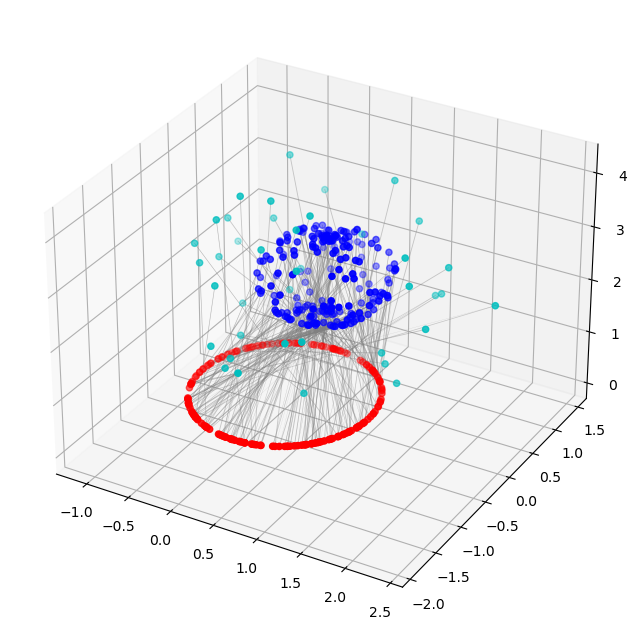

In [19]:

X_src = sphere 
labels_src = labels_3d
X_tar = circle  # Circle
p = np.ones(X_src.shape[0]) / X_src.shape[0]
q = np.ones(X_tar.shape[0]) / X_tar.shape[0]
C1, C2 = get_cost_matrices(X_src, X_tar)
gamma = gromov_wasserstein(C1, C2, p, q, G0=None, thres=1, numItermax=100*X_src.shape[0], tol=1e-5, log=False, verbose=False, line_search=False)
gw_dist = GW_dist(C1, C2, gamma)
print(f'GW for 3D: {gw_dist}')
plot_plan_3d(X_src, X_tar, gamma, labels_src)
